In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os

# Converter a imagem pra escala cinza

In [2]:
paths = [os.path.abspath(os.path.join("./images", path)) for path in os.listdir("./images")]
print(paths[0])
images_gray = []

for path in paths:
    arr_image = [os.path.join(path, f) for f in os.listdir(path)]
    arr_image = [cv2.imread(img) for img in arr_image]
    images_gray.append([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in arr_image])

arr_images_stiff_gray, arr_images_kawamura_gray, arr_images_mitchell_gray, arr_images_glickman_gray = images_gray

c:\Users\joaol\OneDrive\Documentos\Codiguinhos\Python\Ciencia_de_Dados\Testes\Redes_neurais\cnn_model\images\rostos_glickaman


# Reajustando tamanho de imagens

In [3]:
images_cropped = [[] for path in paths]

for index, images in enumerate(images_gray):
   for _, img in enumerate(images): 
        images_cropped[index].append(cv2.resize(img, dsize=(28, 28), interpolation=cv2.INTER_CUBIC))

images_stiff_cropped, images_kawamura_cropped, images_mitchell_cropped, images_glickman_cropped = images_cropped


# Mostrando imagens antes e depois dos reajustes de tamanho

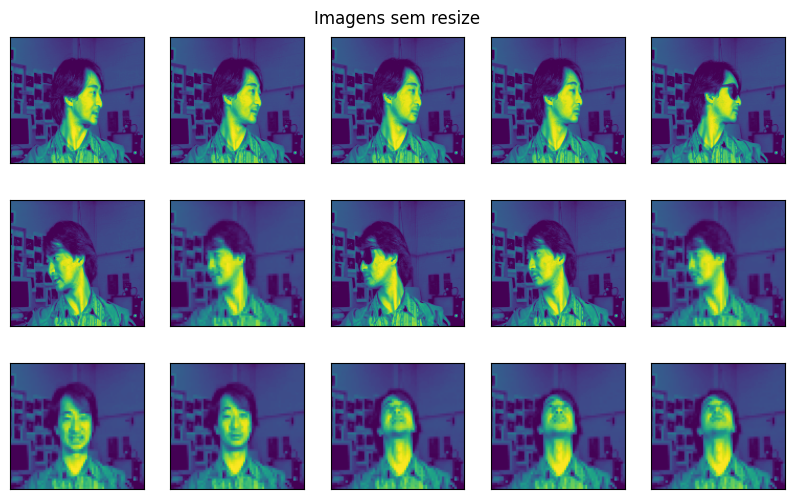

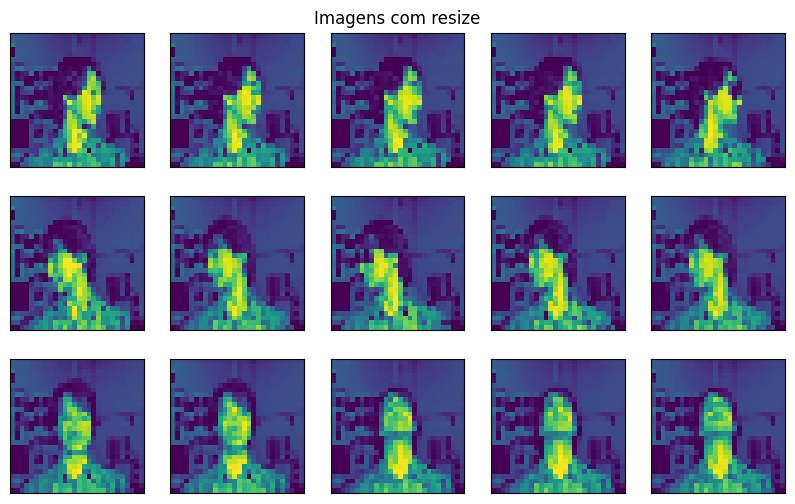

In [4]:
num_rows = 3
num_columns = 5

def create_figure():
    plt.figure(figsize=(2*num_columns, 2*num_rows))
    plt.xticks([])
    plt.yticks([])
    ax = plt.gca()
    ax.set_frame_on(False)

create_figure()

# Imagens antes do resize

def plot(array):
    for i in range(len(array)):
        plt.subplot(num_rows, num_columns, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(array[i])
    plt.show()

plt.title("Imagens sem resize")
plot(arr_images_kawamura_gray)

# Imagens depois do resize
create_figure()

plt.title("Imagens com resize")
plot(images_kawamura_cropped)

# Definição do modelo

In [5]:
from IPython.display import clear_output
import time

In [6]:
def plotGraph(history, loss_history):
    plt.plot(history)
    plt.plot(loss_history)
    plt.title("loss of model")
    plt.xlabel("iterations")
    plt.ylabel("loss")
    plt.legend(["loss_train", "loss test"])
    plt.show()

    clear_output(wait=True)
    time.sleep(1)

In [7]:
class MyCNNModel:
    def __init__(self):
        pass

    def getModel(self):
        return self.model

    def build_Model(self):
        model = tf.keras.Sequential(
            [
                tf.keras.layers.Conv2D(24, kernel_size=(3, 3), activation="relu"),
                tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                tf.keras.layers.Conv2D(36, kernel_size=(3, 3), activation="relu"),
                tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.Dense(10, activation="softmax"),
            ]
        )

        self.model = model

        return model

    def predict(self, test_images):
        print(np.shape(test_images[0]))
        prediction = self.model.predict(test_images)
        prediction = [np.argmax(prediction[i]) for i in range(len(test_images))]
        return prediction

    def evaluate(self, test_images, test_labels):
        return self.model.evaluate(test_images, test_labels, verbose=0)

    def train_model(
        self, train_images, train_labels, batch_size, test_images, test_label
    ):

        history = []
        loss_history = []
        for i in range(self.params["num_epochs"]):

            if hasattr(tqdm, "_instances"):
                tqdm._instances.clear()

            for idx in tqdm(range(0, train_images.shape[0], batch_size)):
                (images, labels) = (
                    train_images[idx : idx + batch_size],
                    train_labels[idx : idx + batch_size],
                )
                tensor = tf.convert_to_tensor(images, dtype=tf.float32)

                with tf.GradientTape() as tape:
                    logits = self.model(images)

                    loss_value = tf.keras.backend.sparse_categorical_crossentropy(
                        labels, logits, from_logits=True
                    )

                history.append(loss_value.numpy().mean())
                loss, acc = self.model.evaluate(test_images, test_label, verbose=0)
                loss_history.append(loss)

                # plotGraph(history, loss_history)

                grads = tape.gradient(loss_value, self.model.trainable_variables)
                self.params["optimizer"].apply_gradients(
                    zip(grads, self.model.trainable_variables)
                )

        plotGraph(history, loss_history)

    def setParams(self, optimizer, loss, metric, num_epochs):
        self.params = {"optimizer": optimizer, "loss": loss, "metric": metric, "num_epochs": num_epochs}
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metric)


In [8]:
cnn_model = MyCNNModel()
cnn_model.build_Model()
cnn_model.setParams(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3),
    loss = "sparse_categorical_crossentropy",
    metric=["accuracy"],
    num_epochs=10
)

# Separação das imagens em conjuntos train/test

In [9]:
train_images = []

for i in range(12):
    train_images.append(images_stiff_cropped[i])
    train_images.append(images_kawamura_cropped[i])
    train_images.append(images_mitchell_cropped[i])
    train_images.append(images_glickman_cropped[i])

train_labels = []

for i in range(12):
    train_labels = train_labels + [0, 1, 2, 3]

print(len(train_labels))
train_labels = np.array(train_labels)


test_images = []

for i in range(12, 15):
    test_images.append(images_stiff_cropped[i])
    test_images.append(images_kawamura_cropped[i])
    test_images.append(images_mitchell_cropped[i])
    test_images.append(images_glickman_cropped[i])


test_labels = []

for i in range(3):
    test_labels = test_labels + [0, 1, 2, 3]

test_labels = np.array(test_labels)

48


In [10]:
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)
train_labels = (train_labels).astype(np.int64)
test_images = (np.expand_dims(test_images, axis=-1)/255.).astype(np.float32)
test_labels = (test_labels).astype(np.int64)


In [11]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [12]:
train_images, train_labels = unison_shuffled_copies(train_images, train_labels)

# Treinamento do modelo

  0%|          | 0/48 [00:00<?, ?it/s]c:\Python311\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


100%|██████████| 48/48 [00:07<00:00,  6.61it/s]


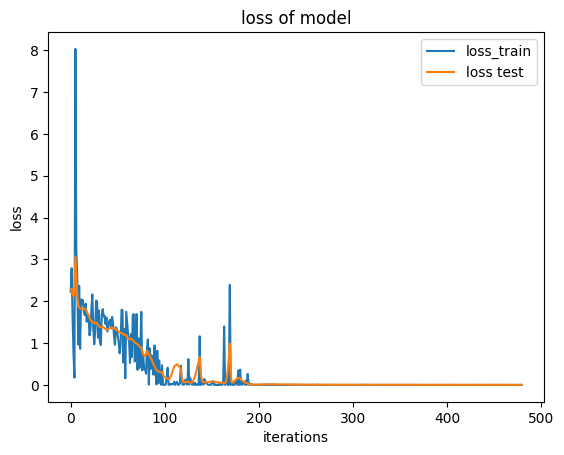

In [13]:
cnn_model.train_model(
    train_images,
    train_labels,
    1,
    test_images,
    test_labels
)

# Mostrando resultados

In [17]:
test_images_not_cropped = []

for i in range(12, 15):
    test_images_not_cropped.append(arr_images_stiff_gray[i])
    test_images_not_cropped.append(arr_images_kawamura_gray[i])
    test_images_not_cropped.append(arr_images_mitchell_gray[i])
    test_images_not_cropped.append(arr_images_glickman_gray[i])

# Ajustar deviado a ordem dos arquivos
targets = np.array(["Glickman", "Kawamura", "Mitchell", "Steffi"])
predictions_number = cnn_model.predict(test_images)
predictions = targets[predictions_number]

print(cnn_model.evaluate(test_images, test_labels))

(28, 28, 1)
1/1 [==============================] - 0s 33ms/step
[0.0018315777415409684, 1.0]


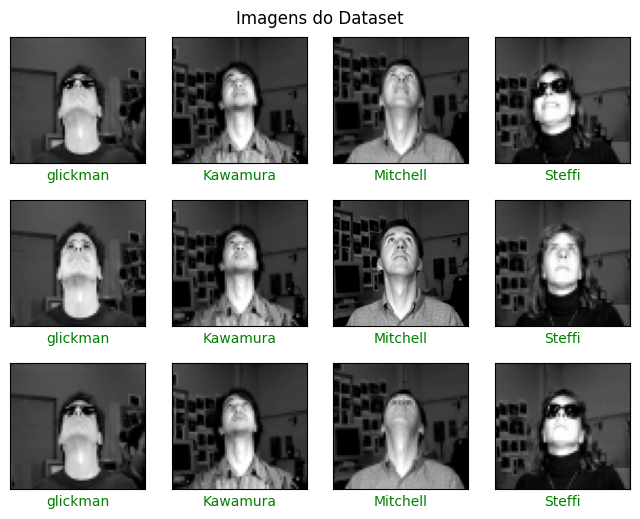

In [18]:
num_rows=3
num_columns=4

plt.figure(figsize=(2*num_columns, 2*num_rows))
plt.title("Imagens do Dataset")
plt.xticks([])
plt.yticks([])
ax = plt.gca()
ax.set_frame_on(False)

for i in range(len(test_images_not_cropped)):
    plt.gray()
    plt.subplot(num_rows, num_columns, i+1)

    if(predictions_number[i] == test_labels[i]):
        plt.xlabel(predictions[i]).set_color("green")
    else:
        plt.xlabel(predictions[i]).set_color("red") 
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_images_not_cropped[i])

plt.show()